In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k13_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_e_k5_b25_k13_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 276)
(1919620, 8)
validation
(288502, 276)
(288502, 8)
test
(221128, 276)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 2048)              567296    


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 3355528 (12.80 MB)


Trainable params: 3355528 (12.80 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 3:32 - loss: 2.2660 - STD: 0.0855 - MAE: 0.2189

 2/20 [==>...........................] - ETA: 5s - loss: 2.1873 - STD: 0.0570 - MAE: 0.2188  

 3/20 [===>..........................] - ETA: 5s - loss: 2.1526 - STD: 0.0439 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 5s - loss: 2.1390 - STD: 0.0393 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.1345 - STD: 0.0381 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.1318 - STD: 0.0373 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.1284 - STD: 0.0361 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 10s - loss: 2.1277 - STD: 0.0347 - MAE: 0.2187

 9/20 [============>.................] - ETA: 9s - loss: 2.1234 - STD: 0.0332 - MAE: 0.2187 

10/20 [==============>...............] - ETA: 7s - loss: 2.1193 - STD: 0.0317 - MAE: 0.2186

11/20 [===============>..............] - ETA: 6s - loss: 2.1156 - STD: 0.0302 - MAE: 0.2186

12/20 [=================>............] - ETA: 5s - loss: 2.1125 - STD: 0.0287 - MAE: 0.2186

13/20 [==================>...........] - ETA: 4s - loss: 2.1100 - STD: 0.0274 - MAE: 0.2186

14/20 [====================>.........] - ETA: 3s - loss: 2.1079 - STD: 0.0264 - MAE: 0.2186

15/20 [=====================>........] - ETA: 2s - loss: 2.1064 - STD: 0.0258 - MAE: 0.2186

16/20 [=======================>......] - ETA: 2s - loss: 2.1052 - STD: 0.0254 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.1042 - STD: 0.0249 - MAE: 0.2187

18/20 [==========================>...] - ETA: 1s - loss: 2.1031 - STD: 0.0244 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1019 - STD: 0.0237 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1007 - STD: 0.0230 - MAE: 0.2187

20/20 [==============================] - 26s 767ms/step - loss: 2.1007 - STD: 0.0230 - MAE: 0.2187 - val_loss: 2.0774 - val_STD: 0.0068 - val_MAE: 0.2186


Epoch 2/10000


 1/20 [>.............................] - ETA: 9s - loss: 2.0781 - STD: 0.0068 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0781 - STD: 0.0074 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 5s - loss: 2.0783 - STD: 0.0083 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 5s - loss: 2.0787 - STD: 0.0091 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 4s - loss: 2.0791 - STD: 0.0098 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 4s - loss: 2.0794 - STD: 0.0102 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 4s - loss: 2.0797 - STD: 0.0105 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 3s - loss: 2.0798 - STD: 0.0107 - MAE: 0.2186

 9/20 [============>.................] - ETA: 3s - loss: 2.0799 - STD: 0.0107 - MAE: 0.2186

10/20 [==============>...............] - ETA: 3s - loss: 2.0798 - STD: 0.0106 - MAE: 0.2186

11/20 [===============>..............] - ETA: 2s - loss: 2.0797 - STD: 0.0104 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.0796 - STD: 0.0102 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.0795 - STD: 0.0099 - MAE: 0.2186

14/20 [====================>.........] - ETA: 1s - loss: 2.0794 - STD: 0.0097 - MAE: 0.2186

15/20 [=====================>........] - ETA: 1s - loss: 2.0793 - STD: 0.0096 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0793 - STD: 0.0094 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0793 - STD: 0.0093 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0793 - STD: 0.0092 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0793 - STD: 0.0091 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0792 - STD: 0.0091 - MAE: 0.2187

20/20 [==============================] - 7s 321ms/step - loss: 2.0792 - STD: 0.0091 - MAE: 0.2187 - val_loss: 2.0771 - val_STD: 0.0074 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 10s - loss: 2.0782 - STD: 0.0074 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 5s - loss: 2.0781 - STD: 0.0074 - MAE: 0.2187 

 3/20 [===>..........................] - ETA: 4s - loss: 2.0781 - STD: 0.0074 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 4s - loss: 2.0780 - STD: 0.0073 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.0780 - STD: 0.0073 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0780 - STD: 0.0073 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 3s - loss: 2.0780 - STD: 0.0073 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 3s - loss: 2.0779 - STD: 0.0073 - MAE: 0.2186

 9/20 [============>.................] - ETA: 3s - loss: 2.0779 - STD: 0.0073 - MAE: 0.2186

10/20 [==============>...............] - ETA: 2s - loss: 2.0779 - STD: 0.0073 - MAE: 0.2186

11/20 [===============>..............] - ETA: 2s - loss: 2.0778 - STD: 0.0073 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.0777 - STD: 0.0074 - MAE: 0.2186

13/20 [==================>...........] - ETA: 1s - loss: 2.0777 - STD: 0.0074 - MAE: 0.2186

14/20 [====================>.........] - ETA: 1s - loss: 2.0776 - STD: 0.0074 - MAE: 0.2186

15/20 [=====================>........] - ETA: 1s - loss: 2.0775 - STD: 0.0073 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0773 - STD: 0.0072 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0772 - STD: 0.0072 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0770 - STD: 0.0071 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0768 - STD: 0.0071 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0765 - STD: 0.0071 - MAE: 0.2186

20/20 [==============================] - 6s 311ms/step - loss: 2.0765 - STD: 0.0071 - MAE: 0.2186 - val_loss: 2.0696 - val_STD: 0.0077 - val_MAE: 0.2184


Epoch 4/10000


 1/20 [>.............................] - ETA: 8s - loss: 2.0709 - STD: 0.0077 - MAE: 0.2184

 2/20 [==>...........................] - ETA: 5s - loss: 2.0697 - STD: 0.0075 - MAE: 0.2184

 3/20 [===>..........................] - ETA: 4s - loss: 2.0684 - STD: 0.0073 - MAE: 0.2183

 4/20 [=====>........................] - ETA: 4s - loss: 2.0671 - STD: 0.0073 - MAE: 0.2183

 5/20 [======>.......................] - ETA: 4s - loss: 2.0655 - STD: 0.0073 - MAE: 0.2183

 6/20 [========>.....................] - ETA: 3s - loss: 2.0636 - STD: 0.0075 - MAE: 0.2182

 7/20 [=========>....................] - ETA: 3s - loss: 2.0614 - STD: 0.0078 - MAE: 0.2181

 8/20 [===========>..................] - ETA: 3s - loss: 2.0589 - STD: 0.0083 - MAE: 0.2180

 9/20 [============>.................] - ETA: 3s - loss: 2.0559 - STD: 0.0088 - MAE: 0.2179

10/20 [==============>...............] - ETA: 2s - loss: 2.0525 - STD: 0.0094 - MAE: 0.2178

11/20 [===============>..............] - ETA: 2s - loss: 2.0486 - STD: 0.0102 - MAE: 0.2176

12/20 [=================>............] - ETA: 2s - loss: 2.0443 - STD: 0.0112 - MAE: 0.2175

13/20 [==================>...........] - ETA: 1s - loss: 2.0432 - STD: 0.0123 - MAE: 0.2173

14/20 [====================>.........] - ETA: 1s - loss: 2.0373 - STD: 0.0136 - MAE: 0.2171

15/20 [=====================>........] - ETA: 1s - loss: 2.0310 - STD: 0.0152 - MAE: 0.2168

16/20 [=======================>......] - ETA: 1s - loss: 2.0245 - STD: 0.0169 - MAE: 0.2165

17/20 [========================>.....] - ETA: 0s - loss: 2.0182 - STD: 0.0188 - MAE: 0.2162

18/20 [==========================>...] - ETA: 0s - loss: 2.0117 - STD: 0.0208 - MAE: 0.2159

19/20 [===========================>..] - ETA: 0s - loss: 2.0052 - STD: 0.0229 - MAE: 0.2156

20/20 [==============================] - ETA: 0s - loss: 1.9991 - STD: 0.0250 - MAE: 0.2152

20/20 [==============================] - 6s 307ms/step - loss: 1.9991 - STD: 0.0250 - MAE: 0.2152 - val_loss: 1.8855 - val_STD: 0.0675 - val_MAE: 0.2083


Epoch 5/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.8764 - STD: 0.0695 - MAE: 0.2078

 2/20 [==>...........................] - ETA: 5s - loss: 1.8745 - STD: 0.0711 - MAE: 0.2075

 3/20 [===>..........................] - ETA: 4s - loss: 1.8735 - STD: 0.0718 - MAE: 0.2074

 4/20 [=====>........................] - ETA: 3s - loss: 1.8730 - STD: 0.0726 - MAE: 0.2072

 5/20 [======>.......................] - ETA: 3s - loss: 1.8701 - STD: 0.0735 - MAE: 0.2070

 6/20 [========>.....................] - ETA: 3s - loss: 1.8672 - STD: 0.0738 - MAE: 0.2069

 7/20 [=========>....................] - ETA: 3s - loss: 1.8646 - STD: 0.0739 - MAE: 0.2068

 8/20 [===========>..................] - ETA: 3s - loss: 1.8625 - STD: 0.0742 - MAE: 0.2067

 9/20 [============>.................] - ETA: 2s - loss: 1.8598 - STD: 0.0743 - MAE: 0.2066

10/20 [==============>...............] - ETA: 2s - loss: 1.8572 - STD: 0.0747 - MAE: 0.2065

11/20 [===============>..............] - ETA: 2s - loss: 1.8549 - STD: 0.0752 - MAE: 0.2063

12/20 [=================>............] - ETA: 2s - loss: 1.8528 - STD: 0.0758 - MAE: 0.2062

13/20 [==================>...........] - ETA: 1s - loss: 1.8502 - STD: 0.0763 - MAE: 0.2060

14/20 [====================>.........] - ETA: 1s - loss: 1.8476 - STD: 0.0768 - MAE: 0.2058

15/20 [=====================>........] - ETA: 1s - loss: 1.8452 - STD: 0.0772 - MAE: 0.2057

16/20 [=======================>......] - ETA: 1s - loss: 1.8425 - STD: 0.0775 - MAE: 0.2055

17/20 [========================>.....] - ETA: 0s - loss: 1.8402 - STD: 0.0780 - MAE: 0.2054

18/20 [==========================>...] - ETA: 0s - loss: 1.8380 - STD: 0.0784 - MAE: 0.2053

19/20 [===========================>..] - ETA: 0s - loss: 1.8354 - STD: 0.0789 - MAE: 0.2051

20/20 [==============================] - ETA: 0s - loss: 1.8329 - STD: 0.0793 - MAE: 0.2050

20/20 [==============================] - 6s 310ms/step - loss: 1.8329 - STD: 0.0793 - MAE: 0.2050 - val_loss: 1.7918 - val_STD: 0.0845 - val_MAE: 0.2028


Epoch 6/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.7889 - STD: 0.0873 - MAE: 0.2021

 2/20 [==>...........................] - ETA: 5s - loss: 1.7815 - STD: 0.0873 - MAE: 0.2019

 3/20 [===>..........................] - ETA: 4s - loss: 1.7761 - STD: 0.0875 - MAE: 0.2018

 4/20 [=====>........................] - ETA: 4s - loss: 1.7742 - STD: 0.0880 - MAE: 0.2016

 5/20 [======>.......................] - ETA: 4s - loss: 1.7706 - STD: 0.0887 - MAE: 0.2014

 6/20 [========>.....................] - ETA: 4s - loss: 1.7668 - STD: 0.0894 - MAE: 0.2012

 7/20 [=========>....................] - ETA: 3s - loss: 1.7638 - STD: 0.0899 - MAE: 0.2010

 8/20 [===========>..................] - ETA: 3s - loss: 1.7614 - STD: 0.0904 - MAE: 0.2008

 9/20 [============>.................] - ETA: 3s - loss: 1.7583 - STD: 0.0906 - MAE: 0.2007

10/20 [==============>...............] - ETA: 2s - loss: 1.7544 - STD: 0.0908 - MAE: 0.2005

11/20 [===============>..............] - ETA: 2s - loss: 1.7510 - STD: 0.0912 - MAE: 0.2004

12/20 [=================>............] - ETA: 2s - loss: 1.7486 - STD: 0.0918 - MAE: 0.2002

13/20 [==================>...........] - ETA: 2s - loss: 1.7460 - STD: 0.0923 - MAE: 0.2000

14/20 [====================>.........] - ETA: 1s - loss: 1.7424 - STD: 0.0927 - MAE: 0.1998

15/20 [=====================>........] - ETA: 1s - loss: 1.7416 - STD: 0.0931 - MAE: 0.1996

16/20 [=======================>......] - ETA: 1s - loss: 1.7387 - STD: 0.0934 - MAE: 0.1995

17/20 [========================>.....] - ETA: 0s - loss: 1.7368 - STD: 0.0939 - MAE: 0.1993

18/20 [==========================>...] - ETA: 0s - loss: 1.7334 - STD: 0.0943 - MAE: 0.1992

19/20 [===========================>..] - ETA: 0s - loss: 1.7301 - STD: 0.0946 - MAE: 0.1990

20/20 [==============================] - ETA: 0s - loss: 1.7277 - STD: 0.0951 - MAE: 0.1989

20/20 [==============================] - 6s 313ms/step - loss: 1.7277 - STD: 0.0951 - MAE: 0.1989 - val_loss: 1.6824 - val_STD: 0.0975 - val_MAE: 0.1972


Epoch 7/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.6706 - STD: 0.1018 - MAE: 0.1958

 2/20 [==>...........................] - ETA: 5s - loss: 1.6654 - STD: 0.1024 - MAE: 0.1955

 3/20 [===>..........................] - ETA: 4s - loss: 1.6665 - STD: 0.1035 - MAE: 0.1953

 4/20 [=====>........................] - ETA: 4s - loss: 1.6661 - STD: 0.1035 - MAE: 0.1953

 5/20 [======>.......................] - ETA: 4s - loss: 1.6625 - STD: 0.1039 - MAE: 0.1951

 6/20 [========>.....................] - ETA: 4s - loss: 1.6602 - STD: 0.1043 - MAE: 0.1949

 7/20 [=========>....................] - ETA: 3s - loss: 1.6598 - STD: 0.1045 - MAE: 0.1948

 8/20 [===========>..................] - ETA: 3s - loss: 1.6582 - STD: 0.1050 - MAE: 0.1946

 9/20 [============>.................] - ETA: 2s - loss: 1.6560 - STD: 0.1053 - MAE: 0.1945

10/20 [==============>...............] - ETA: 2s - loss: 1.6552 - STD: 0.1055 - MAE: 0.1944

11/20 [===============>..............] - ETA: 2s - loss: 1.6547 - STD: 0.1059 - MAE: 0.1943

12/20 [=================>............] - ETA: 2s - loss: 1.6534 - STD: 0.1061 - MAE: 0.1942

13/20 [==================>...........] - ETA: 1s - loss: 1.6520 - STD: 0.1064 - MAE: 0.1941

14/20 [====================>.........] - ETA: 1s - loss: 1.6515 - STD: 0.1069 - MAE: 0.1940

15/20 [=====================>........] - ETA: 1s - loss: 1.6509 - STD: 0.1071 - MAE: 0.1939

16/20 [=======================>......] - ETA: 1s - loss: 1.6495 - STD: 0.1073 - MAE: 0.1938

17/20 [========================>.....] - ETA: 0s - loss: 1.6485 - STD: 0.1076 - MAE: 0.1937

18/20 [==========================>...] - ETA: 0s - loss: 1.6477 - STD: 0.1079 - MAE: 0.1936

19/20 [===========================>..] - ETA: 0s - loss: 1.6468 - STD: 0.1082 - MAE: 0.1935

20/20 [==============================] - ETA: 0s - loss: 1.6459 - STD: 0.1085 - MAE: 0.1934

20/20 [==============================] - 6s 315ms/step - loss: 1.6459 - STD: 0.1085 - MAE: 0.1934 - val_loss: 1.6447 - val_STD: 0.1077 - val_MAE: 0.1938


Epoch 8/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.6285 - STD: 0.1132 - MAE: 0.1917

 2/20 [==>...........................] - ETA: 5s - loss: 1.6296 - STD: 0.1141 - MAE: 0.1915

 3/20 [===>..........................] - ETA: 4s - loss: 1.6292 - STD: 0.1138 - MAE: 0.1915

 4/20 [=====>........................] - ETA: 4s - loss: 1.6273 - STD: 0.1141 - MAE: 0.1914

 5/20 [======>.......................] - ETA: 4s - loss: 1.6267 - STD: 0.1145 - MAE: 0.1913

 6/20 [========>.....................] - ETA: 4s - loss: 1.6270 - STD: 0.1146 - MAE: 0.1913

 7/20 [=========>....................] - ETA: 3s - loss: 1.6271 - STD: 0.1150 - MAE: 0.1912

 8/20 [===========>..................] - ETA: 3s - loss: 1.6265 - STD: 0.1150 - MAE: 0.1912

 9/20 [============>.................] - ETA: 3s - loss: 1.6253 - STD: 0.1151 - MAE: 0.1911

10/20 [==============>...............] - ETA: 2s - loss: 1.6250 - STD: 0.1153 - MAE: 0.1911

11/20 [===============>..............] - ETA: 2s - loss: 1.6248 - STD: 0.1153 - MAE: 0.1911

12/20 [=================>............] - ETA: 2s - loss: 1.6247 - STD: 0.1155 - MAE: 0.1910

13/20 [==================>...........] - ETA: 2s - loss: 1.6238 - STD: 0.1155 - MAE: 0.1910

14/20 [====================>.........] - ETA: 1s - loss: 1.6230 - STD: 0.1156 - MAE: 0.1909

15/20 [=====================>........] - ETA: 1s - loss: 1.6224 - STD: 0.1158 - MAE: 0.1909

16/20 [=======================>......] - ETA: 1s - loss: 1.6217 - STD: 0.1159 - MAE: 0.1908

17/20 [========================>.....] - ETA: 0s - loss: 1.6212 - STD: 0.1161 - MAE: 0.1908

18/20 [==========================>...] - ETA: 0s - loss: 1.6205 - STD: 0.1162 - MAE: 0.1907

19/20 [===========================>..] - ETA: 0s - loss: 1.6197 - STD: 0.1162 - MAE: 0.1907

20/20 [==============================] - ETA: 0s - loss: 1.6196 - STD: 0.1163 - MAE: 0.1906

20/20 [==============================] - 6s 312ms/step - loss: 1.6196 - STD: 0.1163 - MAE: 0.1906 - val_loss: 1.6231 - val_STD: 0.1118 - val_MAE: 0.1921


Epoch 9/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.6039 - STD: 0.1180 - MAE: 0.1896

 2/20 [==>...........................] - ETA: 5s - loss: 1.6047 - STD: 0.1187 - MAE: 0.1895

 3/20 [===>..........................] - ETA: 4s - loss: 1.6052 - STD: 0.1185 - MAE: 0.1896

 4/20 [=====>........................] - ETA: 4s - loss: 1.6033 - STD: 0.1184 - MAE: 0.1895

 5/20 [======>.......................] - ETA: 4s - loss: 1.6032 - STD: 0.1184 - MAE: 0.1895

 6/20 [========>.....................] - ETA: 3s - loss: 1.6023 - STD: 0.1185 - MAE: 0.1895

 7/20 [=========>....................] - ETA: 3s - loss: 1.6015 - STD: 0.1186 - MAE: 0.1894

 8/20 [===========>..................] - ETA: 3s - loss: 1.6008 - STD: 0.1186 - MAE: 0.1893

 9/20 [============>.................] - ETA: 3s - loss: 1.6009 - STD: 0.1187 - MAE: 0.1893

10/20 [==============>...............] - ETA: 2s - loss: 1.6009 - STD: 0.1187 - MAE: 0.1893

11/20 [===============>..............] - ETA: 2s - loss: 1.6006 - STD: 0.1189 - MAE: 0.1893

12/20 [=================>............] - ETA: 2s - loss: 1.6002 - STD: 0.1190 - MAE: 0.1892

13/20 [==================>...........] - ETA: 2s - loss: 1.5988 - STD: 0.1191 - MAE: 0.1892

14/20 [====================>.........] - ETA: 1s - loss: 1.5973 - STD: 0.1192 - MAE: 0.1891

15/20 [=====================>........] - ETA: 1s - loss: 1.5961 - STD: 0.1192 - MAE: 0.1890

16/20 [=======================>......] - ETA: 1s - loss: 1.5952 - STD: 0.1194 - MAE: 0.1889

17/20 [========================>.....] - ETA: 0s - loss: 1.5942 - STD: 0.1194 - MAE: 0.1889

18/20 [==========================>...] - ETA: 0s - loss: 1.5927 - STD: 0.1195 - MAE: 0.1888

19/20 [===========================>..] - ETA: 0s - loss: 1.5908 - STD: 0.1196 - MAE: 0.1887

20/20 [==============================] - ETA: 0s - loss: 1.5905 - STD: 0.1196 - MAE: 0.1886

20/20 [==============================] - 6s 306ms/step - loss: 1.5905 - STD: 0.1196 - MAE: 0.1886 - val_loss: 1.5763 - val_STD: 0.1158 - val_MAE: 0.1891


Epoch 10/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.5511 - STD: 0.1213 - MAE: 0.1864

 2/20 [==>...........................] - ETA: 5s - loss: 1.5509 - STD: 0.1212 - MAE: 0.1865

 3/20 [===>..........................] - ETA: 4s - loss: 1.5490 - STD: 0.1220 - MAE: 0.1862

 4/20 [=====>........................] - ETA: 4s - loss: 1.5477 - STD: 0.1224 - MAE: 0.1860

 5/20 [======>.......................] - ETA: 4s - loss: 1.5445 - STD: 0.1229 - MAE: 0.1857

 6/20 [========>.....................] - ETA: 3s - loss: 1.5413 - STD: 0.1231 - MAE: 0.1855

 7/20 [=========>....................] - ETA: 3s - loss: 1.5365 - STD: 0.1235 - MAE: 0.1852

 8/20 [===========>..................] - ETA: 3s - loss: 1.5322 - STD: 0.1238 - MAE: 0.1849

 9/20 [============>.................] - ETA: 3s - loss: 1.5275 - STD: 0.1242 - MAE: 0.1846

10/20 [==============>...............] - ETA: 2s - loss: 1.5231 - STD: 0.1246 - MAE: 0.1843

11/20 [===============>..............] - ETA: 2s - loss: 1.5205 - STD: 0.1252 - MAE: 0.1841

12/20 [=================>............] - ETA: 2s - loss: 1.5205 - STD: 0.1260 - MAE: 0.1839

13/20 [==================>...........] - ETA: 1s - loss: 1.5195 - STD: 0.1266 - MAE: 0.1837

14/20 [====================>.........] - ETA: 1s - loss: 1.5179 - STD: 0.1277 - MAE: 0.1833

15/20 [=====================>........] - ETA: 1s - loss: 1.5151 - STD: 0.1281 - MAE: 0.1831

16/20 [=======================>......] - ETA: 1s - loss: 1.5120 - STD: 0.1284 - MAE: 0.1829

17/20 [========================>.....] - ETA: 0s - loss: 1.5112 - STD: 0.1291 - MAE: 0.1826

18/20 [==========================>...] - ETA: 0s - loss: 1.5073 - STD: 0.1295 - MAE: 0.1824

19/20 [===========================>..] - ETA: 0s - loss: 1.5051 - STD: 0.1299 - MAE: 0.1822

20/20 [==============================] - ETA: 0s - loss: 1.5024 - STD: 0.1305 - MAE: 0.1819

20/20 [==============================] - 6s 306ms/step - loss: 1.5024 - STD: 0.1305 - MAE: 0.1819 - val_loss: 1.4250 - val_STD: 0.1384 - val_MAE: 0.1767


Epoch 11/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.4463 - STD: 0.1424 - MAE: 0.1765

 2/20 [==>...........................] - ETA: 5s - loss: 1.4484 - STD: 0.1416 - MAE: 0.1769

 3/20 [===>..........................] - ETA: 4s - loss: 1.4393 - STD: 0.1415 - MAE: 0.1765

 4/20 [=====>........................] - ETA: 4s - loss: 1.4416 - STD: 0.1429 - MAE: 0.1762

 5/20 [======>.......................] - ETA: 4s - loss: 1.4370 - STD: 0.1433 - MAE: 0.1758

 6/20 [========>.....................] - ETA: 3s - loss: 1.4351 - STD: 0.1433 - MAE: 0.1758

 7/20 [=========>....................] - ETA: 3s - loss: 1.4302 - STD: 0.1437 - MAE: 0.1755

 8/20 [===========>..................] - ETA: 3s - loss: 1.4296 - STD: 0.1443 - MAE: 0.1752

 9/20 [============>.................] - ETA: 2s - loss: 1.4267 - STD: 0.1444 - MAE: 0.1751

10/20 [==============>...............] - ETA: 2s - loss: 1.4248 - STD: 0.1445 - MAE: 0.1750

11/20 [===============>..............] - ETA: 2s - loss: 1.4219 - STD: 0.1448 - MAE: 0.1748

12/20 [=================>............] - ETA: 2s - loss: 1.4191 - STD: 0.1453 - MAE: 0.1746

13/20 [==================>...........] - ETA: 1s - loss: 1.4169 - STD: 0.1455 - MAE: 0.1744

14/20 [====================>.........] - ETA: 1s - loss: 1.4142 - STD: 0.1459 - MAE: 0.1742

15/20 [=====================>........] - ETA: 1s - loss: 1.4127 - STD: 0.1463 - MAE: 0.1740

16/20 [=======================>......] - ETA: 1s - loss: 1.4104 - STD: 0.1467 - MAE: 0.1738

17/20 [========================>.....] - ETA: 0s - loss: 1.4088 - STD: 0.1469 - MAE: 0.1737

18/20 [==========================>...] - ETA: 0s - loss: 1.4067 - STD: 0.1472 - MAE: 0.1735

19/20 [===========================>..] - ETA: 0s - loss: 1.4050 - STD: 0.1475 - MAE: 0.1734

20/20 [==============================] - ETA: 0s - loss: 1.4031 - STD: 0.1477 - MAE: 0.1732

20/20 [==============================] - 6s 306ms/step - loss: 1.4031 - STD: 0.1477 - MAE: 0.1732 - val_loss: 1.3465 - val_STD: 0.1493 - val_MAE: 0.1702


Epoch 12/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.3652 - STD: 0.1518 - MAE: 0.1704

 2/20 [==>...........................] - ETA: 5s - loss: 1.3659 - STD: 0.1524 - MAE: 0.1702

 3/20 [===>..........................] - ETA: 4s - loss: 1.3693 - STD: 0.1527 - MAE: 0.1703

 4/20 [=====>........................] - ETA: 4s - loss: 1.3731 - STD: 0.1526 - MAE: 0.1705

 5/20 [======>.......................] - ETA: 4s - loss: 1.3736 - STD: 0.1529 - MAE: 0.1704

 6/20 [========>.....................] - ETA: 4s - loss: 1.3726 - STD: 0.1532 - MAE: 0.1703

 7/20 [=========>....................] - ETA: 3s - loss: 1.3697 - STD: 0.1533 - MAE: 0.1701

 8/20 [===========>..................] - ETA: 3s - loss: 1.3689 - STD: 0.1533 - MAE: 0.1701

 9/20 [============>.................] - ETA: 3s - loss: 1.3695 - STD: 0.1533 - MAE: 0.1701

10/20 [==============>...............] - ETA: 2s - loss: 1.3685 - STD: 0.1534 - MAE: 0.1700

11/20 [===============>..............] - ETA: 2s - loss: 1.3672 - STD: 0.1534 - MAE: 0.1700

12/20 [=================>............] - ETA: 2s - loss: 1.3655 - STD: 0.1535 - MAE: 0.1699

13/20 [==================>...........] - ETA: 2s - loss: 1.3639 - STD: 0.1537 - MAE: 0.1697

14/20 [====================>.........] - ETA: 1s - loss: 1.3631 - STD: 0.1538 - MAE: 0.1697

15/20 [=====================>........] - ETA: 1s - loss: 1.3628 - STD: 0.1540 - MAE: 0.1695

16/20 [=======================>......] - ETA: 1s - loss: 1.3615 - STD: 0.1542 - MAE: 0.1694

17/20 [========================>.....] - ETA: 0s - loss: 1.3604 - STD: 0.1543 - MAE: 0.1693

18/20 [==========================>...] - ETA: 0s - loss: 1.3595 - STD: 0.1545 - MAE: 0.1693

19/20 [===========================>..] - ETA: 0s - loss: 1.3584 - STD: 0.1546 - MAE: 0.1691

20/20 [==============================] - ETA: 0s - loss: 1.3575 - STD: 0.1548 - MAE: 0.1691

20/20 [==============================] - 6s 311ms/step - loss: 1.3575 - STD: 0.1548 - MAE: 0.1691 - val_loss: 1.3199 - val_STD: 0.1544 - val_MAE: 0.1673


Epoch 13/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.3408 - STD: 0.1568 - MAE: 0.1677

 2/20 [==>...........................] - ETA: 5s - loss: 1.3390 - STD: 0.1570 - MAE: 0.1676

 3/20 [===>..........................] - ETA: 4s - loss: 1.3387 - STD: 0.1572 - MAE: 0.1675

 4/20 [=====>........................] - ETA: 4s - loss: 1.3376 - STD: 0.1570 - MAE: 0.1675

 5/20 [======>.......................] - ETA: 4s - loss: 1.3360 - STD: 0.1571 - MAE: 0.1674

 6/20 [========>.....................] - ETA: 4s - loss: 1.3353 - STD: 0.1572 - MAE: 0.1673

 7/20 [=========>....................] - ETA: 3s - loss: 1.3345 - STD: 0.1573 - MAE: 0.1672

 8/20 [===========>..................] - ETA: 3s - loss: 1.3336 - STD: 0.1575 - MAE: 0.1671

 9/20 [============>.................] - ETA: 3s - loss: 1.3332 - STD: 0.1576 - MAE: 0.1671

10/20 [==============>...............] - ETA: 2s - loss: 1.3324 - STD: 0.1577 - MAE: 0.1670

11/20 [===============>..............] - ETA: 2s - loss: 1.3321 - STD: 0.1577 - MAE: 0.1669

12/20 [=================>............] - ETA: 2s - loss: 1.3317 - STD: 0.1578 - MAE: 0.1669

13/20 [==================>...........] - ETA: 2s - loss: 1.3316 - STD: 0.1579 - MAE: 0.1669

14/20 [====================>.........] - ETA: 1s - loss: 1.3311 - STD: 0.1579 - MAE: 0.1668

15/20 [=====================>........] - ETA: 1s - loss: 1.3305 - STD: 0.1581 - MAE: 0.1667

16/20 [=======================>......] - ETA: 1s - loss: 1.3303 - STD: 0.1582 - MAE: 0.1667

17/20 [========================>.....] - ETA: 0s - loss: 1.3300 - STD: 0.1583 - MAE: 0.1666

18/20 [==========================>...] - ETA: 0s - loss: 1.3302 - STD: 0.1585 - MAE: 0.1666

19/20 [===========================>..] - ETA: 0s - loss: 1.3306 - STD: 0.1585 - MAE: 0.1666

20/20 [==============================] - ETA: 0s - loss: 1.3302 - STD: 0.1586 - MAE: 0.1665

20/20 [==============================] - 6s 312ms/step - loss: 1.3302 - STD: 0.1586 - MAE: 0.1665 - val_loss: 1.3017 - val_STD: 0.1582 - val_MAE: 0.1649


Epoch 14/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.3169 - STD: 0.1608 - MAE: 0.1651

 2/20 [==>...........................] - ETA: 5s - loss: 1.3192 - STD: 0.1602 - MAE: 0.1654

 3/20 [===>..........................] - ETA: 4s - loss: 1.3195 - STD: 0.1603 - MAE: 0.1654

 4/20 [=====>........................] - ETA: 4s - loss: 1.3189 - STD: 0.1603 - MAE: 0.1654

 5/20 [======>.......................] - ETA: 4s - loss: 1.3180 - STD: 0.1603 - MAE: 0.1653

 6/20 [========>.....................] - ETA: 4s - loss: 1.3170 - STD: 0.1604 - MAE: 0.1652

 7/20 [=========>....................] - ETA: 3s - loss: 1.3169 - STD: 0.1606 - MAE: 0.1651

 8/20 [===========>..................] - ETA: 3s - loss: 1.3165 - STD: 0.1608 - MAE: 0.1650

 9/20 [============>.................] - ETA: 2s - loss: 1.3161 - STD: 0.1609 - MAE: 0.1650

10/20 [==============>...............] - ETA: 2s - loss: 1.3155 - STD: 0.1611 - MAE: 0.1649

11/20 [===============>..............] - ETA: 2s - loss: 1.3152 - STD: 0.1611 - MAE: 0.1649

12/20 [=================>............] - ETA: 2s - loss: 1.3145 - STD: 0.1612 - MAE: 0.1648

13/20 [==================>...........] - ETA: 1s - loss: 1.3140 - STD: 0.1613 - MAE: 0.1648

14/20 [====================>.........] - ETA: 1s - loss: 1.3134 - STD: 0.1614 - MAE: 0.1647

15/20 [=====================>........] - ETA: 1s - loss: 1.3127 - STD: 0.1615 - MAE: 0.1647

16/20 [=======================>......] - ETA: 1s - loss: 1.3124 - STD: 0.1616 - MAE: 0.1646

17/20 [========================>.....] - ETA: 0s - loss: 1.3120 - STD: 0.1616 - MAE: 0.1646

18/20 [==========================>...] - ETA: 0s - loss: 1.3119 - STD: 0.1617 - MAE: 0.1645

19/20 [===========================>..] - ETA: 0s - loss: 1.3113 - STD: 0.1618 - MAE: 0.1645

20/20 [==============================] - ETA: 0s - loss: 1.3109 - STD: 0.1619 - MAE: 0.1644

20/20 [==============================] - 6s 314ms/step - loss: 1.3109 - STD: 0.1619 - MAE: 0.1644 - val_loss: 1.2958 - val_STD: 0.1613 - val_MAE: 0.1636


Epoch 15/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.3093 - STD: 0.1631 - MAE: 0.1639

 2/20 [==>...........................] - ETA: 5s - loss: 1.3106 - STD: 0.1638 - MAE: 0.1637

 3/20 [===>..........................] - ETA: 5s - loss: 1.3127 - STD: 0.1636 - MAE: 0.1638

 4/20 [=====>........................] - ETA: 4s - loss: 1.3134 - STD: 0.1642 - MAE: 0.1637

 5/20 [======>.......................] - ETA: 4s - loss: 1.3129 - STD: 0.1641 - MAE: 0.1637

 6/20 [========>.....................] - ETA: 4s - loss: 1.3116 - STD: 0.1643 - MAE: 0.1636

 7/20 [=========>....................] - ETA: 3s - loss: 1.3101 - STD: 0.1643 - MAE: 0.1636

 8/20 [===========>..................] - ETA: 3s - loss: 1.3083 - STD: 0.1642 - MAE: 0.1635

 9/20 [============>.................] - ETA: 3s - loss: 1.3077 - STD: 0.1643 - MAE: 0.1635

10/20 [==============>...............] - ETA: 2s - loss: 1.3075 - STD: 0.1642 - MAE: 0.1634

11/20 [===============>..............] - ETA: 2s - loss: 1.3069 - STD: 0.1643 - MAE: 0.1634

12/20 [=================>............] - ETA: 2s - loss: 1.3062 - STD: 0.1643 - MAE: 0.1634

13/20 [==================>...........] - ETA: 1s - loss: 1.3051 - STD: 0.1645 - MAE: 0.1633

14/20 [====================>.........] - ETA: 1s - loss: 1.3047 - STD: 0.1646 - MAE: 0.1632

15/20 [=====================>........] - ETA: 1s - loss: 1.3044 - STD: 0.1646 - MAE: 0.1632

16/20 [=======================>......] - ETA: 1s - loss: 1.3038 - STD: 0.1647 - MAE: 0.1631

17/20 [========================>.....] - ETA: 0s - loss: 1.3034 - STD: 0.1647 - MAE: 0.1631

18/20 [==========================>...] - ETA: 0s - loss: 1.3028 - STD: 0.1648 - MAE: 0.1631

19/20 [===========================>..] - ETA: 0s - loss: 1.3024 - STD: 0.1648 - MAE: 0.1630

20/20 [==============================] - ETA: 0s - loss: 1.3019 - STD: 0.1649 - MAE: 0.1630

20/20 [==============================] - 6s 311ms/step - loss: 1.3019 - STD: 0.1649 - MAE: 0.1630 - val_loss: 1.2840 - val_STD: 0.1644 - val_MAE: 0.1618


Epoch 16/10000


 1/20 [>.............................] - ETA: 8s - loss: 1.2986 - STD: 0.1665 - MAE: 0.1623

 2/20 [==>...........................] - ETA: 5s - loss: 1.2956 - STD: 0.1658 - MAE: 0.1624

 3/20 [===>..........................] - ETA: 4s - loss: 1.2932 - STD: 0.1662 - MAE: 0.1621

 4/20 [=====>........................] - ETA: 3s - loss: 1.2932 - STD: 0.1663 - MAE: 0.1621

 5/20 [======>.......................] - ETA: 3s - loss: 1.2942 - STD: 0.1664 - MAE: 0.1622

 6/20 [========>.....................] - ETA: 3s - loss: 1.2985 - STD: 0.1664 - MAE: 0.1623

 7/20 [=========>....................] - ETA: 3s - loss: 1.3009 - STD: 0.1665 - MAE: 0.1623

 8/20 [===========>..................] - ETA: 3s - loss: 1.3018 - STD: 0.1664 - MAE: 0.1624

 9/20 [============>.................] - ETA: 2s - loss: 1.3013 - STD: 0.1667 - MAE: 0.1623

10/20 [==============>...............] - ETA: 2s - loss: 1.3005 - STD: 0.1667 - MAE: 0.1623

11/20 [===============>..............] - ETA: 2s - loss: 1.3002 - STD: 0.1667 - MAE: 0.1622

12/20 [=================>............] - ETA: 2s - loss: 1.2998 - STD: 0.1668 - MAE: 0.1622

13/20 [==================>...........] - ETA: 1s - loss: 1.2991 - STD: 0.1667 - MAE: 0.1622

14/20 [====================>.........] - ETA: 1s - loss: 1.2987 - STD: 0.1668 - MAE: 0.1622

15/20 [=====================>........] - ETA: 1s - loss: 1.2985 - STD: 0.1668 - MAE: 0.1622

16/20 [=======================>......] - ETA: 1s - loss: 1.2981 - STD: 0.1667 - MAE: 0.1621

17/20 [========================>.....] - ETA: 0s - loss: 1.2976 - STD: 0.1668 - MAE: 0.1621

18/20 [==========================>...] - ETA: 0s - loss: 1.2968 - STD: 0.1668 - MAE: 0.1621

19/20 [===========================>..] - ETA: 0s - loss: 1.2966 - STD: 0.1669 - MAE: 0.1620

20/20 [==============================] - ETA: 0s - loss: 1.2961 - STD: 0.1670 - MAE: 0.1620

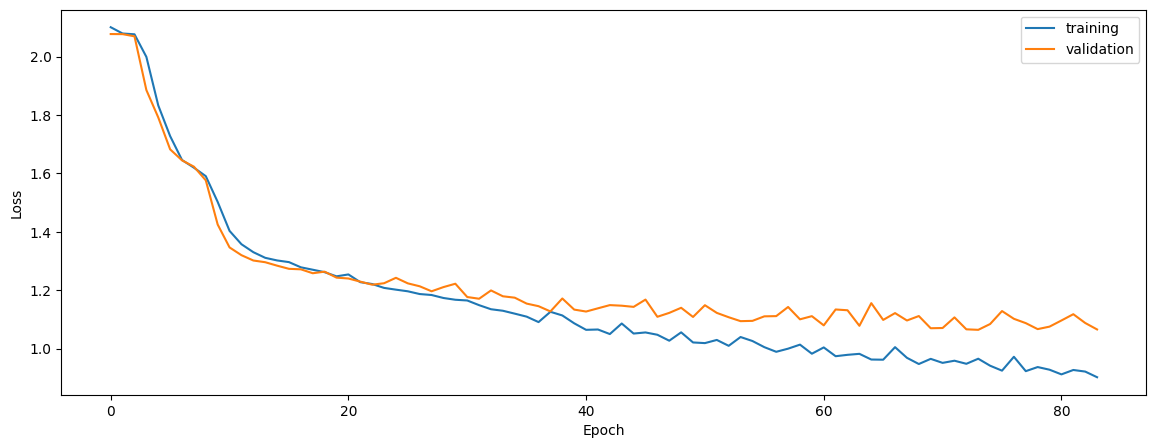

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6396208624623624


0.5912922614054669


0.5671556745414421


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.4819603322731482


0.51072355698033


0.432960306520571


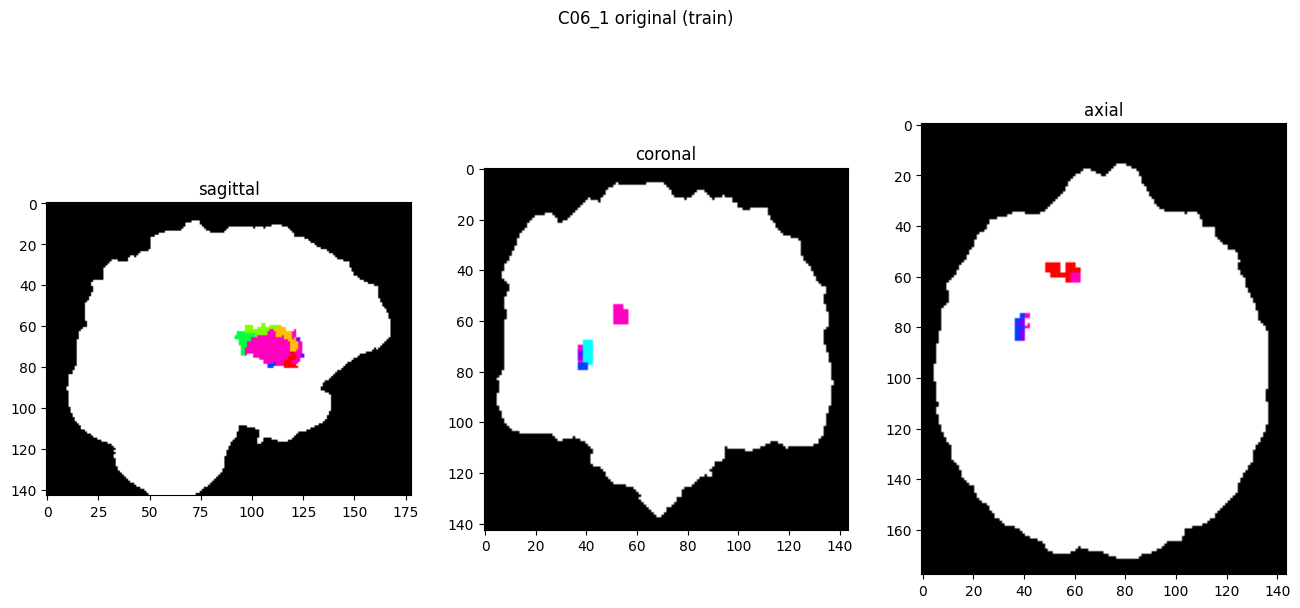

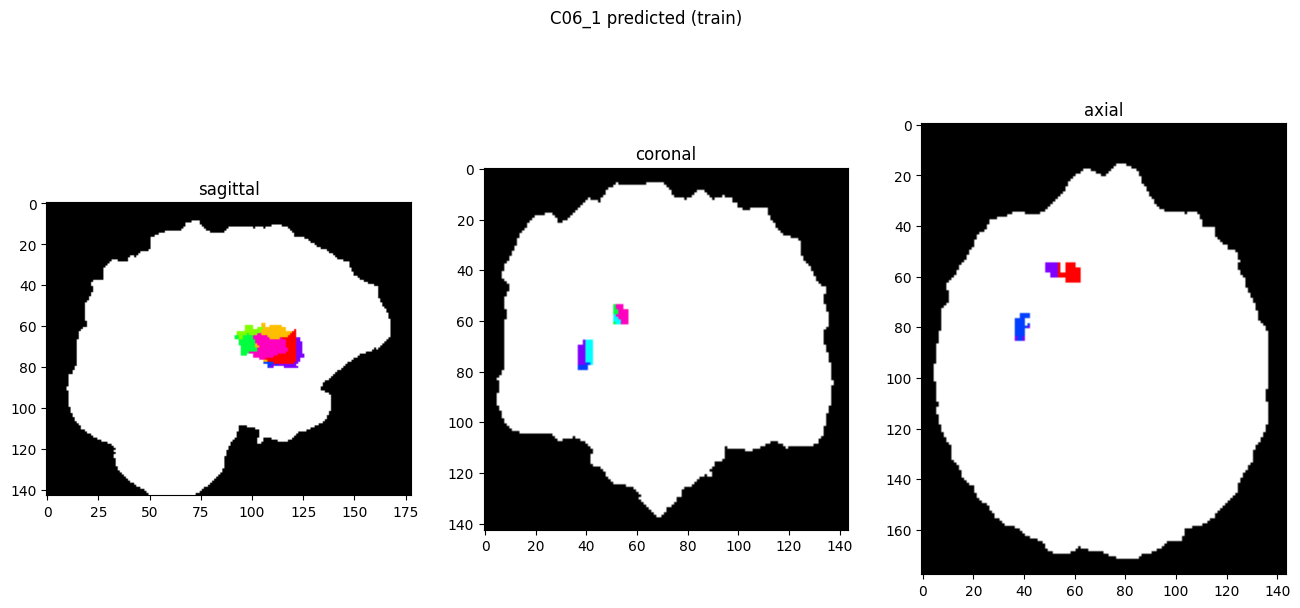

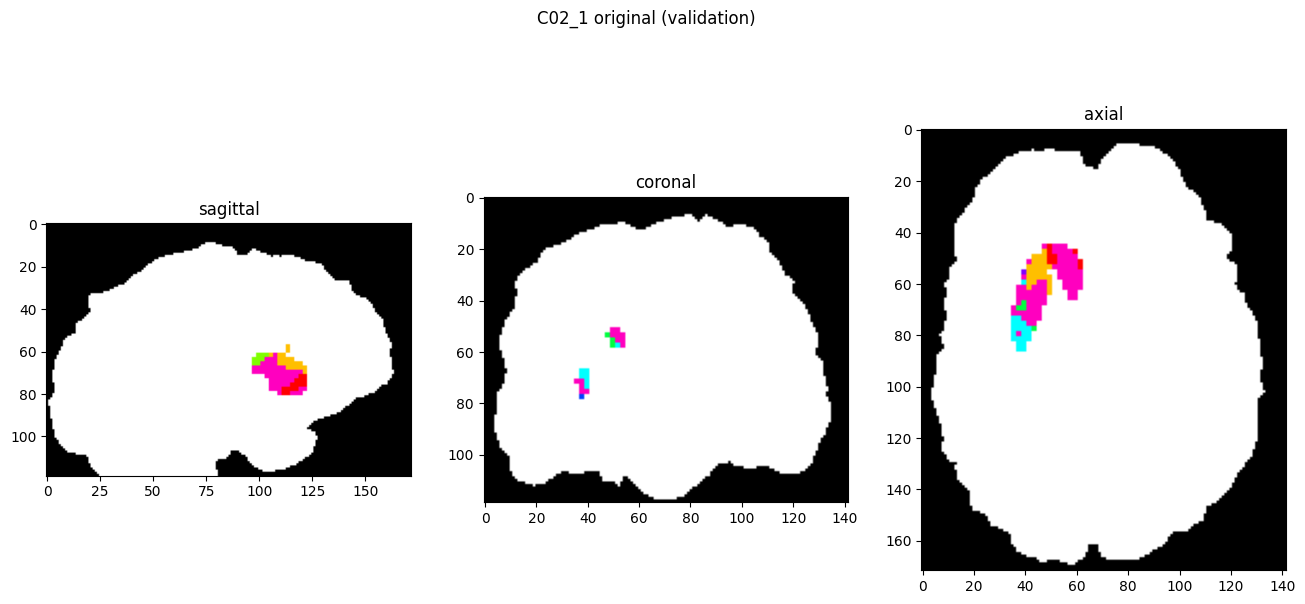

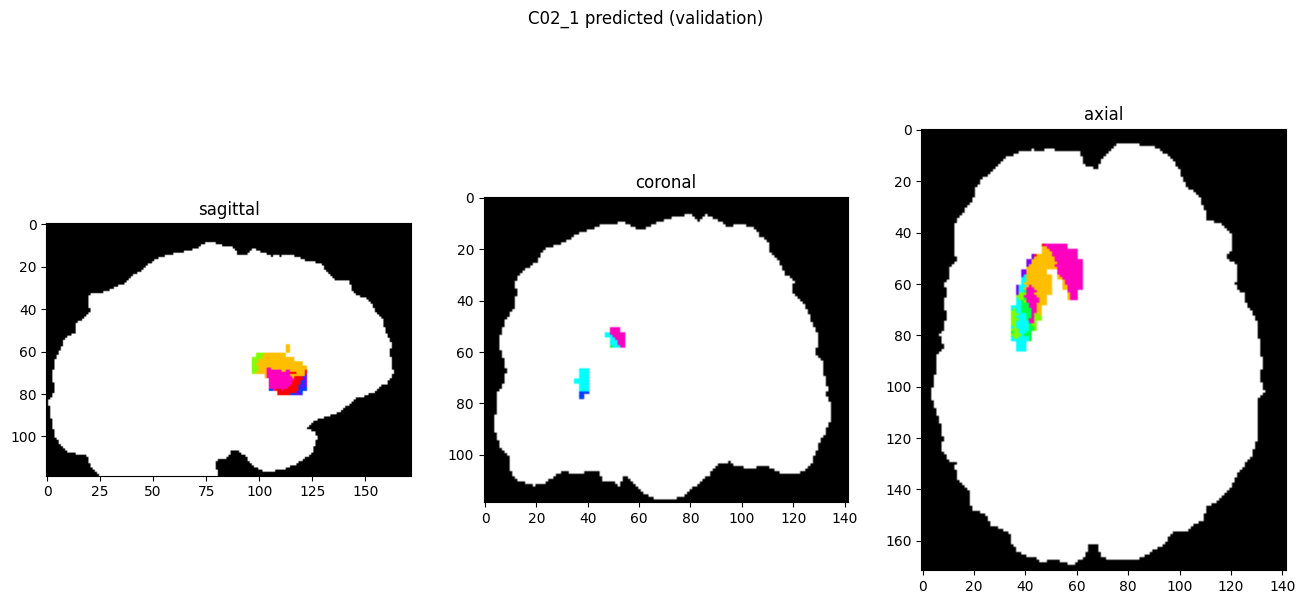

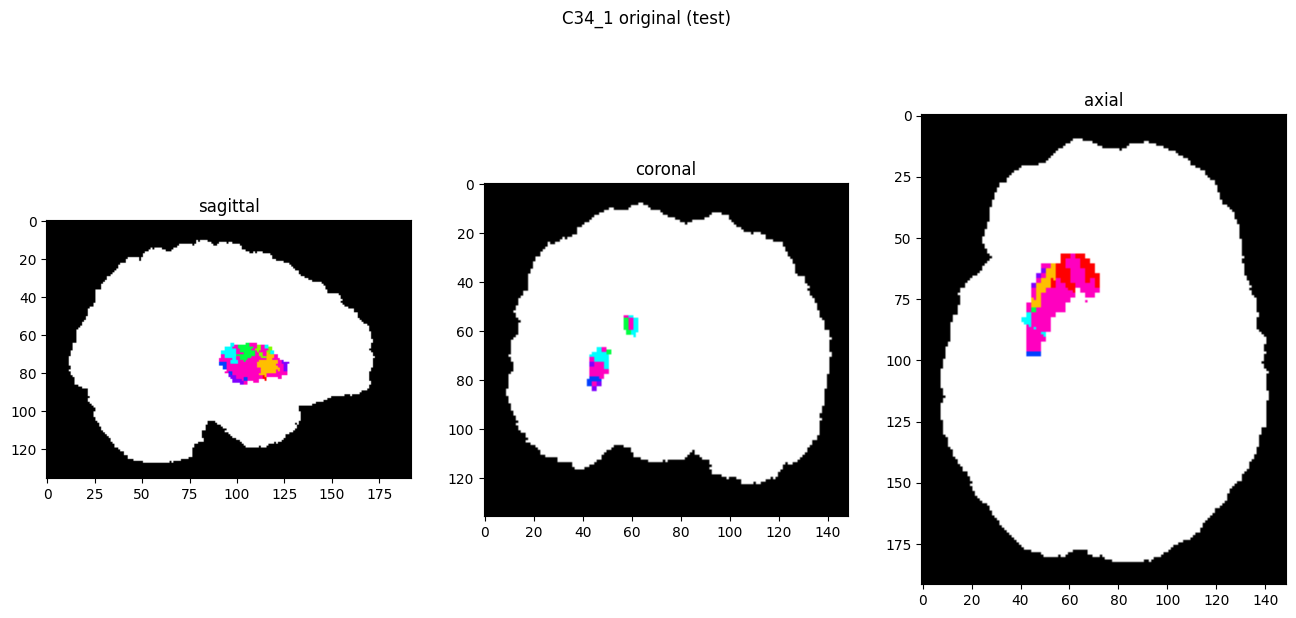

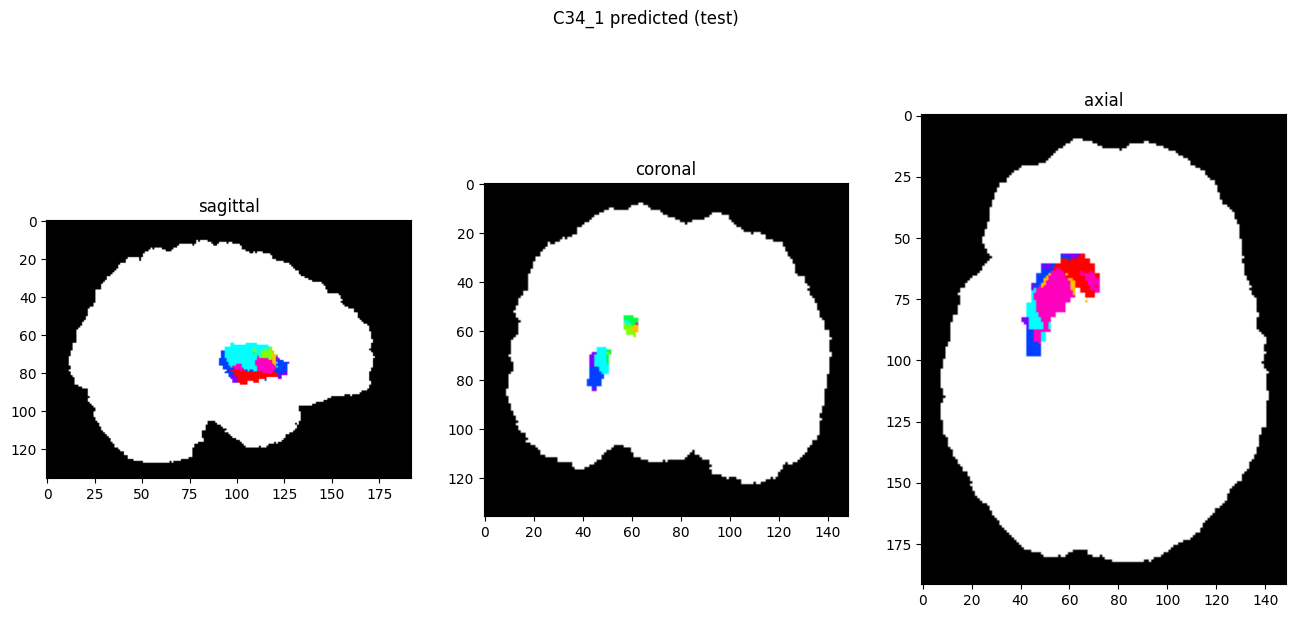

In [9]:
showResults(model, gen, threshold=0)